In [1]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

In [2]:
#set seed for reproduction
set.seed(1)

#searching for input variables with zero variance (without the varible Intensity)
x <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(x, 2, var) == 0
x <- x[,!idx.zero.var]

#attache Intensity as factor
x$Intensity <- as.factor(train.data$Intensity)

data <- x
data$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS

In [4]:
library(randomForest)
library(tidymodels)

#Function for Cross-Validation and Predictions
fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ ., mtry = 1000, ntree = 500, maxnodes = 30) {
    random.Forest <- randomForest::randomForest(VALENCE.PLEASANTNESS ~ ., fold, mtry = mtry, ntree = ntree, maxnodes = maxnodes)
    valid.set <- assessment(fold)
    mean((valid.set$VALENCE.PLEASANTNESS - predict(random.Forest, valid.set))^2)
}

#Cross-Validation set
validation_data <- vfold_cv(data, v = 5)  

mtry <- seq.int(1000,1100,2)
ntree <- seq.int(100, 2000, 25)
maxnodes <- seq.int(25,35)

cv.errors_mtry <- c()
cv.errors_ntree <- c()
cv.errors_maxnodes <- c()

We choose to set the three parameters mtry, ntree and maxnodes of the basic random Forest model to common values:
- $ mtry = 1000 \sim \frac{predicotrs}{3} $
- $ntree = 500$ medium value, to keep the computational burden within a limit but to reduce the variance enough
- $maxnodes = 30$ medium value, in order to catch the complex dependencies but to not overfit the training data

In the next section, we will sequently Cross-validate the three parameters. We will start with mtry and we will evaluate different values around the start value. Afterwards, we will set mtry to the best one and evaluate in the same way ntree. Again, we will also fix ntree to the best value, so that we will finally evaluate maxnodes.

## Cross-Validation of the parameters

In [5]:
#Iteration of mtry (mtry around sqrt(number of predictors))
for (i in mtry){   
    cv.errors_mtry <- rbind(cv.errors_mtry, sapply(validation_data$splits, fit_and_evaluate, mtry = i))
}

Saving 6.67 x 6.67 in image



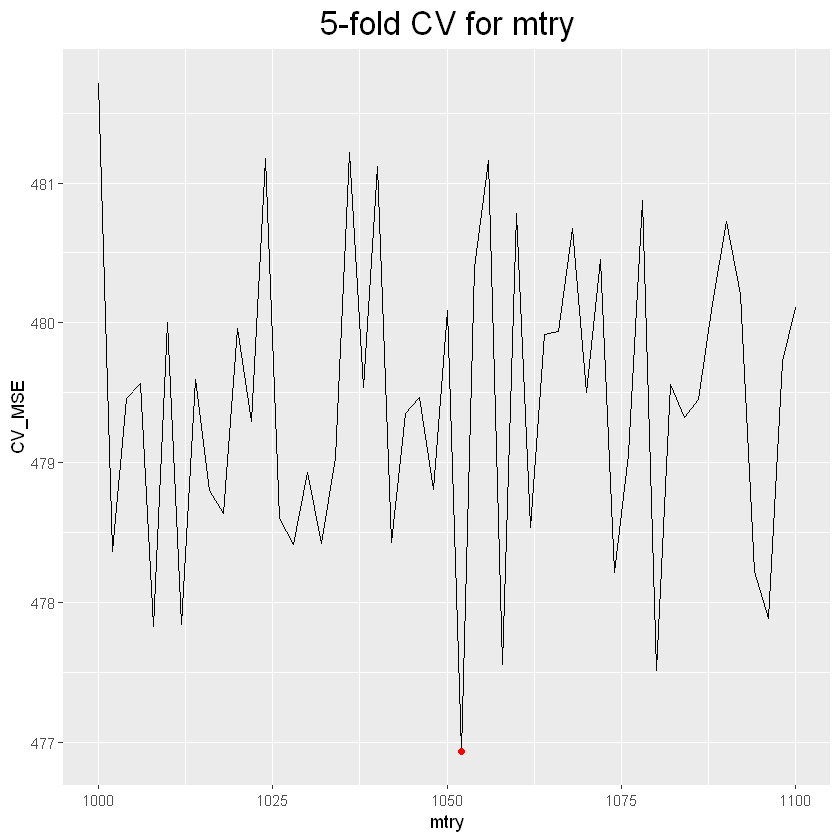

In [6]:
mean.cv.errors_mtry <- rowMeans(cv.errors_mtry)
cv.min_mtry <- which.min(mean.cv.errors_mtry)
mtry.best <- mtry[cv.min_mtry]

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

mtry.data <- data.frame("mtry" = mtry, "CV_MSE" = mean.cv.errors_mtry)
mtry.data %>% ggplot(aes(x = mtry, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for mtry") + 
geom_point(aes(mtry.best, mean.cv.errors_mtry[cv.min_mtry]), col = "red")

ggsave("../Pictures/mtry_1.png")

In [7]:
cat("The best mtry is = ", mtry.best, "with an error of ", mean.cv.errors_mtry[cv.min_mtry])

The best mtry is =  1052 with an error of  476.9343

In [8]:
#Iteration of ntree
for (i in ntree){   
    cv.errors_ntree <- rbind(cv.errors_ntree, sapply(validation_data$splits, fit_and_evaluate, mtry = mtry.best, ntree = i))
}

Saving 6.67 x 6.67 in image



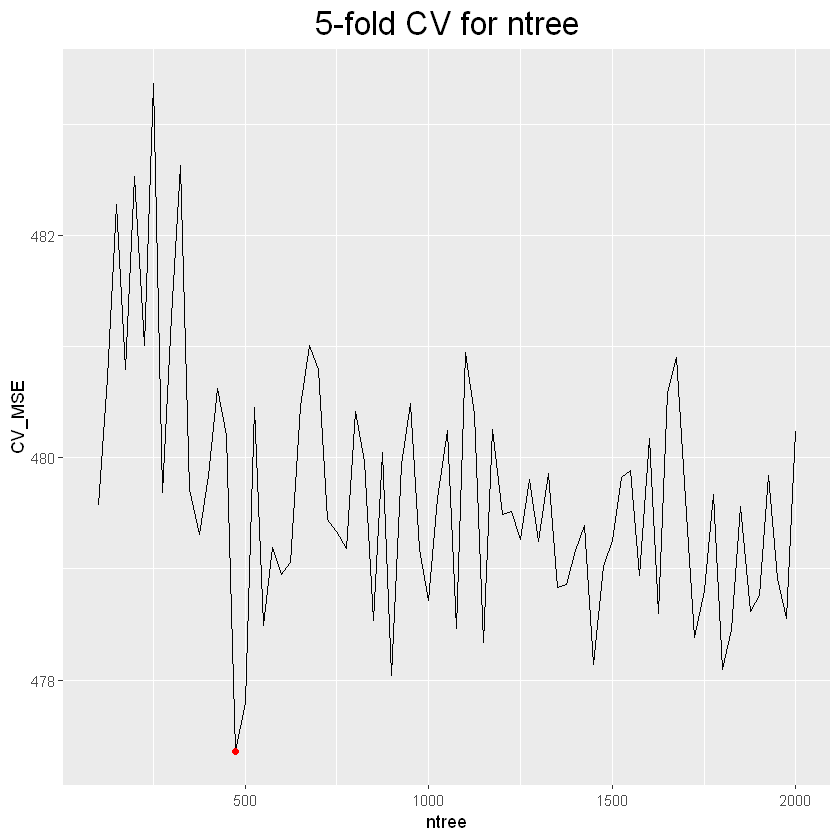

In [9]:
mean.cv.errors_ntree <- rowMeans(cv.errors_ntree)
cv.min_ntree <- which.min(mean.cv.errors_ntree)
ntree.best <- ntree[cv.min_ntree]

ntree.data <- data.frame("ntree" = ntree, "CV_MSE" = mean.cv.errors_ntree)
ntree.data %>% ggplot(aes(x = ntree, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for ntree") + 
geom_point(aes(ntree.best, mean.cv.errors_ntree[cv.min_ntree]), col = "red")

ggsave("../Pictures/ntree_1.png")

In [10]:
#Iteration of maxnodes
for (i in maxnodes){   
    cv.errors_maxnodes <- rbind(cv.errors_maxnodes, sapply(validation_data$splits, fit_and_evaluate, mtry = mtry.best, ntree = ntree.best, maxnodes = i))
}

Saving 6.67 x 6.67 in image



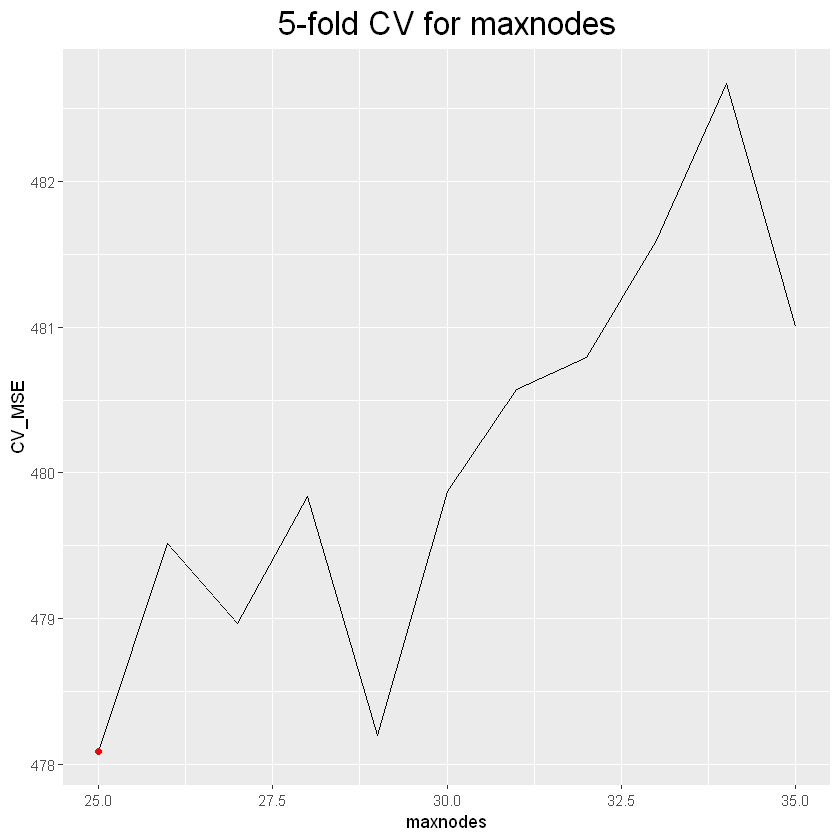

In [11]:
mean.cv.errors_maxnodes <- rowMeans(cv.errors_maxnodes)
cv.min_maxnodes <- which.min(mean.cv.errors_maxnodes)
maxnodes.best <- maxnodes[cv.min_maxnodes]

maxnodes.data <- data.frame("maxnodes" = maxnodes, "CV_MSE" = mean.cv.errors_maxnodes)
maxnodes.data %>% ggplot(aes(x = maxnodes, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for maxnodes") + 
geom_point(aes(maxnodes.best, mean.cv.errors_maxnodes[cv.min_maxnodes]), col = "red")

ggsave("../Pictures/maxnodes_1.png")

In [12]:
cat("The optimal parameters are: mtry = ", mtry.best, " ntree = ", ntree.best, " and maxnodes = ", maxnodes.best)

The optimal parameters are: mtry =  1052  ntree =  475  and maxnodes =  25

## Validation of best Model

In [15]:
library(randomForest)
library(tidymodels)

random.forest.validation <- function(seed){
    set.seed(seed)
    len <- length(data[,1])
    idx.train <- sample(1:len, 2*len/3)
    train <- data[idx.train, ]
    validation <- data[-idx.train, ]

    r.Forest <- randomForest::randomForest(VALENCE.PLEASANTNESS ~ ., train, mtry = 1052, ntree = 475, maxnodes = 25)
    prediction <- predict(r.Forest, validation)
    mean((prediction - validation$VALENCE.PLEASANTNESS)^2)
    
}
seeds <- seq.int(100,150)
MSEs <- sapply(seeds, random.forest.validation)
mean.MSE <- mean(sqrt(MSEs))
var <- var(sqrt(MSEs))
cat("The mean RMSE is = ", mean.MSE, " and the variance is = ", var)

The mean RMSE is =  21.72485  and the variance is =  0.7337022

## Submission

In [1]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

In [2]:
#Random Forest Submission
set.seed(1)
#Preparation of training and test data
train <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(train, 2, var) == 0

train <- train[,!idx.zero.var]
test <- test.data[,-c(1,2)]
test <- test[,!idx.zero.var]

test$Intensity <- as.factor(test.data$Intensity)
train$Intensity <- as.factor(train.data$Intensity)


#test intensity is always at level high, so that the prediction function has a problem (cheat with adding a row that afterwards is substracted)
test <- rbind(test, train[1,])


train$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS

r.Forest <- randomForest::randomForest(VALENCE.PLEASANTNESS ~ ., train, mtry = 1052, ntree = 475, maxnodes = 25)
random.Forest.prediction <- predict(r.Forest, test)

#substracting added row
len <- length(random.Forest.prediction)
random.Forest.prediction <- random.Forest.prediction[-len]


In [3]:
#Creation of csv submission-file
submission <- data.frame(Id = 1:68, VALENCE.PLEASANTNESS = random.Forest.prediction)
write.csv(submission, file = "../Submissions/random_forest.csv", row.names = FALSE)